In [1]:
%%time

import pandas as pd

train = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')

CPU times: user 12.9 s, sys: 1.05 s, total: 13.9 s
Wall time: 19.7 s


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


- Fill NaN values

In [4]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [5]:
numeric_train = train.select_dtypes(include=['float64', 'int64'])
numeric_test = test.select_dtypes(include=['float64', 'int64'])

- Capped Outliers

In [6]:
# Cap outliers in train
capped_train = numeric_train.copy()
for col in capped_train.columns:
    Q1 = capped_train[col].quantile(0.25)
    Q3 = capped_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    capped_train[col] = capped_train[col].clip(lower=lower_bound, upper=upper_bound)

# Cap outliers in test
capped_test = numeric_test.copy()
for col in capped_test.columns:
    Q1 = capped_test[col].quantile(0.25)
    Q3 = capped_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    capped_test[col] = capped_test[col].clip(lower=lower_bound, upper=upper_bound)

capped_train, capped_test

(        target    var_0   var_1    var_2   var_3    var_4    var_5   var_6  \
 0            0   8.9255 -6.7863  11.9081  5.0930  11.4607  -9.2834  5.1187   
 1            0  11.5006 -4.1473  13.8588  5.3890  12.3622   7.0433  5.6208   
 2            0   8.6093 -2.7457  12.0805  7.8928  10.5825  -9.0837  6.9427   
 3            0  11.0604 -2.1518   8.9522  7.1957  12.5846  -1.8361  5.8428   
 4            0   9.8369 -1.4834  12.8746  6.6375  12.2772   2.4486  5.9405   
 ...        ...      ...     ...      ...     ...      ...      ...     ...   
 199995       0  11.4880 -0.4956   8.2622  3.5142  10.3404  11.6081  5.6709   
 199996       0   4.9149 -2.4484  16.7052  6.6345   8.3096 -10.5628  5.8802   
 199997       0  11.2232 -5.0518  10.5127  5.6456   9.3410  -5.4086  4.5555   
 199998       0   9.7148 -8.6098  13.6104  5.7930  12.5173   0.5339  6.0479   
 199999       0  10.8762 -5.7105  12.1183  8.0328  11.5577   0.3488  5.2839   
 
           var_7   var_8  ...  var_190  var_191  v

- Setup features and target

In [7]:
features = capped_train.drop(columns=['target']).columns

In [8]:
target = capped_train['target']

- Model training

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9965 - loss: 0.0287 - val_accuracy: 1.0000 - val_loss: 2.8879e-14
Epoch 2/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 1.5385e-07 - val_accuracy: 1.0000 - val_loss: 2.8669e-15
Epoch 3/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 1.8708e-08 - val_accuracy: 1.0000 - val_loss: 3.4407e-18
Epoch 4/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 6.6148e-10 - val_accuracy: 1.0000 - val_loss: 4.3156e-20
Epoch 5/5
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 1.3013e-10 - val_accuracy: 1.0000 - val_loss: 1.5800e-23
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  


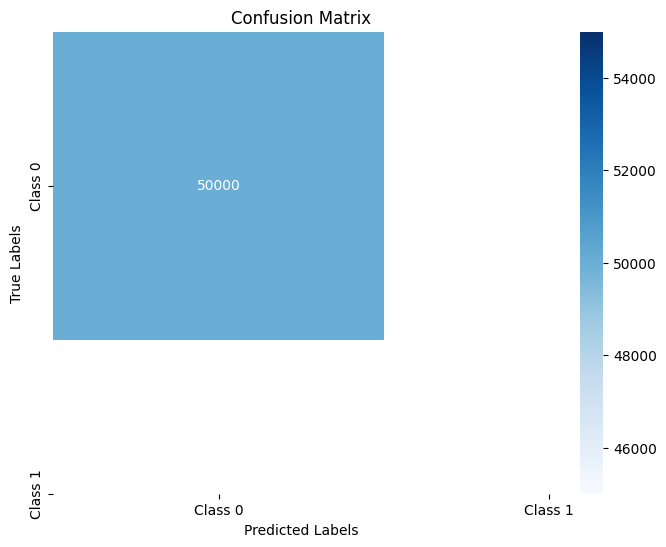

CPU times: user 1min 6s, sys: 8.18 s, total: 1min 14s
Wall time: 45.6 s


In [12]:
%%time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the neural network model architecture for binary classification
def build_binary_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Prepare the data 
X = train[features].values
y = target.values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Build and train the model
model = build_binary_model(input_dim=X_train.shape[1])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

# Predict probabilities on the validation dataset
y_pred_proba_val = model.predict(X_val)

# Convert probabilities to class predictions
y_pred_classes_val = (y_pred_proba_val > 0.5).astype(int)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_val, y_pred_classes_val)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Predict probabilities on the test dataset
X_test = test[features].values
y_pred_proba_test = model.predict(X_test)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 964us/step


In [18]:
import joblib

# Save the trained pipeline to a .pkl file
joblib.dump(model, 'santander_customer_transaction_model.pkl')

['santander_customer_transaction_model.pkl']